# Arbres toulousains

Données sources :
- localisation des arbres : https://data.toulouse-metropole.fr/explore/dataset/arbres-urbains
- géométrie des quartiers de Toulouse : https://data.toulouse-metropole.fr/explore/dataset/quartiers-de-democratie-locale

J'utilise ici les geojson 

TODO :
- ajouter les arbres d'alignement

In [46]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, Point
import json
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster

In [21]:
url = "https://data.toulouse-metropole.fr/api/explore/v2.1/catalog/datasets/quartiers-de-democratie-locale/exports/geojson"
df_quartiers = gpd.read_file(url)

In [14]:
url = "https://data.toulouse-metropole.fr/api/explore/v2.1/catalog/datasets/arbres-urbains/exports/geojson"
df_arbres = gpd.read_file(url)

In [39]:
df = df_arbres.sjoin(df_quartiers, how="inner", predicate='intersects')

In [26]:
df.head()

,id,longitude,latitude,famille,cultivar_variete,genre,espece,statut,hauteur,diametre,...,date_plantation,remarquable,geometry,index_right,geo_point_2d,quartier_secteur,secteur,quartier,nom_quartier,nom_secteur
0,43609,43.612452,1.421931,Fagacees,None,Quercus,ilex,1 - Arbre vivant (AV),6,12,...,None,None,POINT (1.42193 43.61245),7,"{'lon': 1.430922413500507, 'lat': 43.626866245...",3.1 Toulouse Nord,3,3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Toulouse Nord
1,43619,43.612115,1.422100,Fagacees,None,Quercus,ilex,1 - Arbre vivant (AV),9,14,...,None,None,POINT (1.42210 43.61211),7,"{'lon': 1.430922413500507, 'lat': 43.626866245...",3.1 Toulouse Nord,3,3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Toulouse Nord
2,43622,43.612268,1.422047,Fagacees,None,Quercus,ilex,1 - Arbre vivant (AV),9,19,...,None,None,POINT (1.42205 43.61227),7,"{'lon': 1.430922413500507, 'lat': 43.626866245...",3.1 Toulouse Nord,3,3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Toulouse Nord
3,43636,43.613453,1.421690,Cupressacees,None,Cupressus,sempervirens,1 - Arbre vivant (AV),6,10,...,None,None,POINT (1.42169 43.61345),7,"{'lon': 1.430922413500507, 'lat': 43.626866245...",3.1 Toulouse Nord,3,3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Toulouse Nord
4,43639,43.614136,1.421482,Fagacees,None,Quercus,ilex,1 - Arbre vivant (AV),8,17,...,None,None,POINT (1.42148 43.61414),7,"{'lon': 1.430922413500507, 'lat': 43.626866245...",3.1 Toulouse Nord,3,3.1,Minimes / Barrière de Paris / Ponts-Jumeaux,Toulouse Nord


In [42]:
df.latitude.mean()

1.4349593484300285

In [51]:
# Assuming df is your DataFrame and it has 'latitude' and 'longitude' columns
# Convert the 'geometry' column to latitude and longitude if it's in another format
#df['latitude'] = df.geometry.y
#df['longitude'] = df.geometry.x

# Create a base map
#m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=13)
m = folium.Map(location=[df.longitude.mean(), df.latitude.mean()], zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(m)  # Adding alternative tiles

# Create a FastMarkerCluster object
#marker_cluster = MarkerCluster(data=list(zip(df['longitude'], df['latitude'])))
#marker_cluster = FastMarkerCluster(data=list(zip(df['longitude'], df['latitude'])))

locations = list(zip(df['longitude'], df['latitude']))
popups = ["lon:{}<br>lat:{}".format(lon, lat) for (lat, lon) in locations]

icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: '<b>' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""


marker_cluster = MarkerCluster(
    locations=locations,
    popups=popups,
    name="1000 clustered icons",
    overlay=True,
    control=True,
    icon_create_function=icon_create_function,
)

# Add the FastMarkerCluster object to the map
marker_cluster.add_to(m)

# Save the map to an HTML file
m.save("carte.html")

In [53]:
df.keys()

Index(['id', 'longitude', 'latitude', 'famille', 'cultivar_variete', 'genre',
       'espece', 'statut', 'hauteur', 'diametre', 'diametre_couronne',
       'date_plantation', 'remarquable', 'geometry', 'index_right',
       'geo_point_2d', 'quartier_secteur', 'secteur', 'quartier',
       'nom_quartier', 'nom_secteur'],
      dtype='object')

In [55]:
# Count the number of trees in each neighborhood
tree_counts = df.groupby('quartier_secteur').size()

# Sum the couronne sizes in each neighborhood
sum_couronne_sizes = df.groupby('quartier_secteur')['diametre_couronne'].sum()

# Combine both results into a single DataFrame
neighborhood_aggregates = pd.DataFrame({
    'tree_count': tree_counts,
    'total_couronne_size': sum_couronne_sizes
}).reset_index()

# Display the result
print(neighborhood_aggregates)

            quartier_secteur  tree_count  total_couronne_size
0        1.1 Toulouse Centre        1820              -128682
1        1.2 Toulouse Centre        3364              -228084
2        1.3 Toulouse Centre        1425               -28981
3   2.1 Toulouse Rive Gauche        2223                -3553
4   2.2 Toulouse Rive Gauche        1804               -27912
5   2.3 Toulouse Rive Gauche        4787              -644990
6   2.4 Toulouse Rive Gauche        4487              -567258
7          3.1 Toulouse Nord        3048              -122071
8          3.2 Toulouse Nord        8719                 -397
9          3.3 Toulouse Nord        7739              -312749
10          4.1 Toulouse Est        3790              -148683
11          4.2 Toulouse Est        4972               -37518
12          4.3 Toulouse Est        6662              -277185
13      5.1 Toulouse Sud Est        9792              -945752
14      5.2 Toulouse Sud Est        5612             -1073236
15      

In [70]:
outlier_threshold_low = 0.1
outlier_threshold_high = 30  # You can set this based on your data

count_per_neighborhood = df['quartier_secteur'].value_counts()
#print(count_per_neighborhood)

# Calculate the sum of diametre_couronne per neighborhood, ignoring outliers
sum_per_neighborhood = df[df['diametre_couronne'].between(outlier_threshold_low, outlier_threshold_high)].groupby('quartier_secteur')['diametre_couronne'].mean()

# Combine the results
result = pd.concat([count_per_neighborhood, sum_per_neighborhood], axis=1)
result.columns = ['Nombre arbres', 'Taille de couronne moyenne']

# Show the result
print(result)

                          Nombre arbres  Taille de couronne moyenne
quartier_secteur                                                   
5.1 Toulouse Sud Est               9792                    7.298770
6.3 Toulouse Ouest                 9727                    6.867541
5.3 Toulouse Sud Est               8962                    8.153310
3.2 Toulouse Nord                  8719                    7.029606
6.2 Toulouse Ouest                 8021                    5.842742
3.3 Toulouse Nord                  7739                    5.063401
4.3 Toulouse Est                   6662                    7.314961
5.2 Toulouse Sud Est               5612                    8.186962
6.4 Toulouse Ouest                 5463                    5.579038
4.2 Toulouse Est                   4972                    6.370180
2.3 Toulouse Rive Gauche           4787                    6.388889
2.4 Toulouse Rive Gauche           4487                    6.902314
4.1 Toulouse Est                   3790         

In [66]:
df[df['diametre_couronne'].between(outlier_threshold_low, outlier_threshold_high)]['diametre_couronne'].max

<bound method Series.max of 0          4
1          5
2          7
3          2
4          5
          ..
107645     7
108817    12
109053    15
110817    20
110907     2
Name: diametre_couronne, Length: 48253, dtype: int64>

<Axes: >

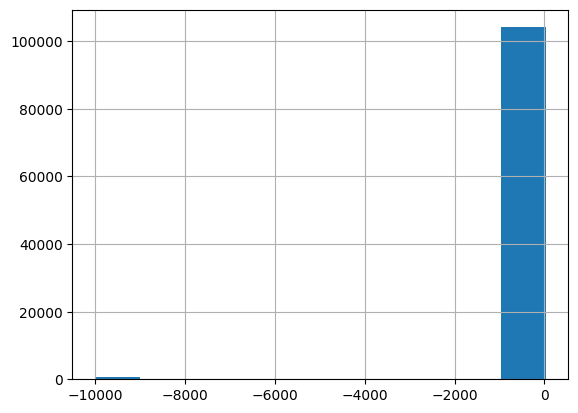

In [57]:
df.diametre_couronne.hist()

In [35]:
m = df[['diametre_couronne', 'quartier_secteur', 'geometry']].explore(
      column='diametre_couronne',  # make choropleth based on "BoroName" column
      #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
      #categorical=True,
      cmap = 'RdYlGn',
      marker_kwds=dict(radius=10, fill=True), # make marker radius 10px with fill
      legend=False, # show legend
      tooltip=False,
      popup=True,
      k=5, # use 10 bins
      vmin=1, vmax=5,
      tiles=None,
      #legend_kwds= dict(caption='Moyenne des notes (de 1 à 5)', colorbar=True, max_labels=5),
      #name=list_var_display[0], # name of the layer in the map
      missing_kwds={'color': 'darkgrey', 'label': 'Pas de réponse'},
      overlay=False
 )
folium.TileLayer('cartodbpositron', control=False).add_to(m)  # use folium to add alternative tiles
m.save("carte.html")

In [4]:
tree_data_filepath = './data/arbres-urbains.csv'
neighborhood_data_filepath = './data/quartiers-de-democratie-locale.csv'

In [5]:
def load_tree_data(filepath):
    # Load tree data from a CSV file
    df = pd.read_csv(filepath, delimiter=';')
    # Create Point geometry for each tree
    df['geometry'] = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    df = df.rename(columns={'geometry': 'geometry_point'})
    gdf = gpd.GeoDataFrame(df, geometry='geometry_point')
    gdf.set_crs(epsg=4326, inplace=True)  # Assuming the coordinates are in WGS 84
    return gdf

def load_neighborhood_data(filepath):
    # Load neighborhood data from a CSV file
    df = pd.read_csv(filepath, delimiter=';')
    # Convert the 'Geo Shape' column from JSON to a geometry object
    df['geometry'] = df['Geo Shape'].apply(lambda x: shape(json.loads(x)))
    #df = df.rename(columns={'Geo Shape': 'geometry'})
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)  # Ensure the CRS matches the tree data
    return gdf

def perform_spatial_join(trees_gdf, neighborhoods_gdf):
    # Perform the spatial join
    joined = gpd.sjoin(trees_gdf, neighborhoods_gdf, how="left", op="within")
    return joined

In [6]:
# Load data, CRS and inspect 1st few geometries
trees_gdf = load_tree_data(tree_data_filepath)
print("Trees CRS:", trees_gdf.crs)
print("First few tree geometries:", trees_gdf.geometry.head())

Trees CRS: EPSG:4326
First few tree geometries: 0    POINT (43.57423 1.40219)
1    POINT (43.57307 1.40119)
2    POINT (43.57345 1.40120)
3    POINT (43.57419 1.40198)
4    POINT (43.57363 1.40125)
Name: geometry_point, dtype: geometry


In [8]:
trees_gdf.keys()

Index(['id', 'longitude', 'latitude', 'Geo Point', 'famille',
       'cultivar variete', 'genre', 'espece', 'statut', 'hauteur', 'diametre',
       'diametre_couronne', 'date_plantation', 'remarquable',
       'geometry_point'],
      dtype='object')

In [10]:
trees_gdf["Geo Point"]

0          43.57423086893773, 1.4021914138404008
1          43.57307335811948, 1.4011937208801282
2          43.57344583424449, 1.4012045118646927
3           43.57418719004558, 1.401983220598764
4          43.57362912547214, 1.4012532790518575
                           ...                  
111299    43.587123636144206, 1.4031550312255892
111300     43.584282564278155, 1.410245393527829
111301     43.584425879747066, 1.410317083236464
111302      43.583895233047485, 1.40950944779974
111303      43.58443685418466, 1.410165955459405
Name: Geo Point, Length: 111304, dtype: object

In [7]:
# Load data, CRS and inspect 1st few geometries
neighborhoods_gdf = load_neighborhood_data(neighborhood_data_filepath)
print("Neighborhoods CRS:", neighborhoods_gdf.crs)
print("First few neighborhood geometries:", neighborhoods_gdf.geometry.head())

Neighborhoods CRS: EPSG:4326
First few neighborhood geometries: 0    MULTIPOLYGON (((1.43559 43.60180, 1.43687 43.6...
1    MULTIPOLYGON (((1.43904 43.63488, 1.43908 43.6...
2    MULTIPOLYGON (((1.45687 43.60516, 1.45732 43.6...
3    MULTIPOLYGON (((1.43677 43.54471, 1.43677 43.5...
4    MULTIPOLYGON (((1.43434 43.60376, 1.43459 43.6...
Name: geometry, dtype: geometry


In [ ]:
# Perform spatial join and check
joined_data = perform_spatial_join(trees_gdf, neighborhoods_gdf)
print("Joined data sample:", joined_data.head())

In [ ]:
# Visualize the data (optional, requires matplotlib)
fig, ax = plt.subplots()
trees_gdf.plot(ax=ax, color='blue', markersize=5)
neighborhoods_gdf.boundary.plot(ax=ax, color='red')
plt.show()

In [ ]:
# Perform spatial join
#joined_data = perform_spatial_join(trees_gdf, neighborhoods_gdf)
joined_data = gpd.sjoin(trees_gdf, neighborhoods_gdf, how="left", op="within")
#joined_data = trees_gdf.sjoin(neighborhoods_gdf, how="left")